<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza D.
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Sofía Callejas
- Nombre de alumno 2: Iván Meneses


### **Link de repositorio de GitHub:** https://github.com/ivanandresmt/lab_10.git

### Indice

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**.
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias.
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
try:
    from google.colab import drive

    drive.mount("/content/drive")
    path = "/content/drive/My Drive/"
except:
    print('Ignorando conexión drive-colab')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/lab_10/diabetes_data.csv')
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo una buena elección de las features?.

In [3]:
!pip install xgboost

In [4]:
df.columns

Index(['Age', 'Sex', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'DiffWalk',
       'Stroke', 'HighBP', 'Diabetes'],
      dtype='object')

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBClassifier


# Dividir características (X) y variable objetivo (y)
X = df.drop('Diabetes', axis=1)
y = df['Diabetes']


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir transformaciones para las características
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder()

#vamos a separar las variables cualitativas y cantitativas y usar un standarizador

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ['Age', 'BMI', 'PhysHlth']),
        ('cat', categorical_transformer, ['Sex', 'Smoker','HighChol','CholCheck','HeartDiseaseorAttack','PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'DiffWalk',
       'Stroke', 'HighBP'])
    ])


# Definir el modelo XGBoost
model = XGBClassifier()

# Crear el pipeline con el preprocesador y el modelo
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Entrenar el modelo
pipeline.fit(X_train, y_train)

# Evaluar el modelo en el conjunto de prueba
accuracy = pipeline.score(X_test, y_test)
print("Exactitud del modelo: {:.2f}".format(accuracy))




Exactitud del modelo: 0.75


## 3. Importancia de las features con XGBoost (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la **importancia de las features** del modelo entrenado utilizando todos los métodos (*weight*, *cover*, *gain*) que posee xgboost usando `plot_importance`. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

<Figure size 1000x600 with 0 Axes>

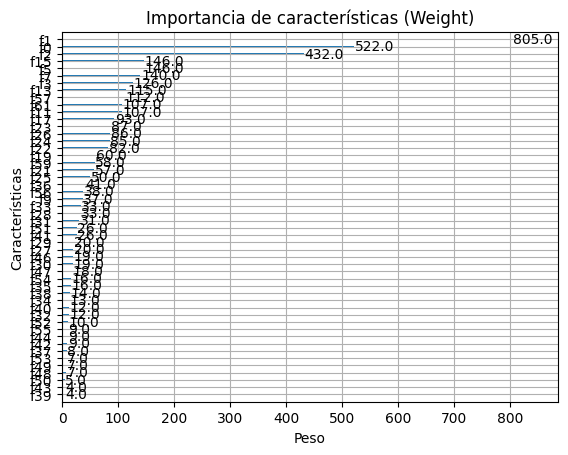

<Figure size 1000x600 with 0 Axes>

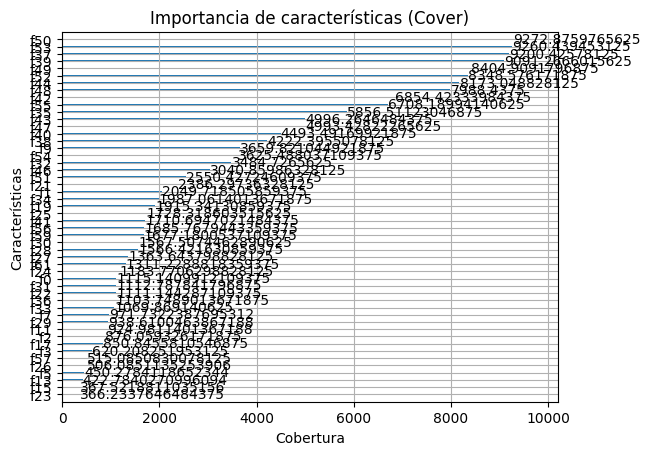

<Figure size 1000x600 with 0 Axes>

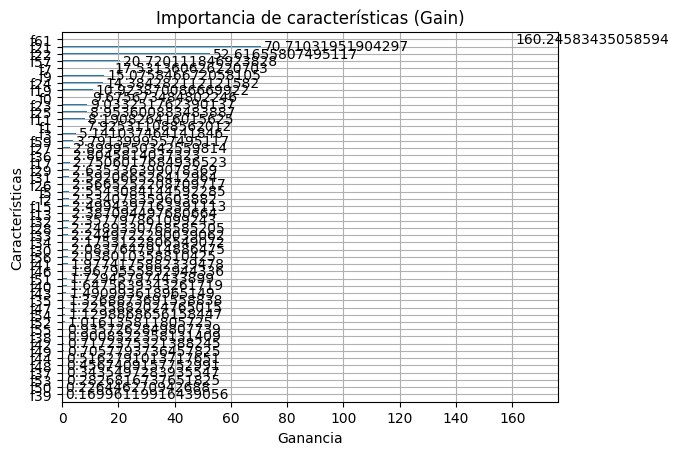

In [6]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Obtener la importancia de las características según weight
plt.figure(figsize=(10, 6))
plot_importance(pipeline.named_steps['model'], importance_type='weight')
plt.title('Importancia de características (Weight)')
plt.xlabel('Peso')
plt.ylabel('Características')
plt.show()

# Obtener la importancia de las características según cover
plt.figure(figsize=(10, 6))
plot_importance(pipeline.named_steps['model'], importance_type='cover')
plt.title('Importancia de características (Cover)')
plt.xlabel('Cobertura')
plt.ylabel('Características')
plt.show()

# Obtener la importancia de las características según gain
plt.figure(figsize=(10, 6))
plot_importance(pipeline.named_steps['model'], importance_type='gain')
plt.title('Importancia de características (Gain)')
plt.xlabel('Ganancia')
plt.ylabel('Características')
plt.show()

weight: Esta métrica calcula la cantidad total de veces que una característica se utiliza para dividir los nodos a lo largo de todos los árboles del modelo. Mide la importancia de la característica en términos de su frecuencia de uso en el modelo.

cover: La métrica de cover calcula la cobertura promedio de las características (la proporción de muestras afectadas por las divisiones que utilizan una característica) a lo largo de todos los árboles del modelo. Mide la importancia de la característica en términos de su alcance en las muestras del conjunto de datos.

gain: Esta métrica mide la ganancia promedio de las características en términos de la reducción de la función de pérdida cuando se utiliza la característica para dividir los nodos del árbol. Mide la importancia de la característica en términos de su contribución a la mejora del modelo.

Este metodo en general es muy bueno para ver la importancia de caracteristicas pero no es suficiente en este caso, dado que se puede ver que una correlacion revelante entre las variables.

En terminos de debilidades, hay que escoger que las variables no se correlaciones entre si ademas, los árboles pueden capturar interacciones no lineales entre características, pero la interpretación exacta de estas interacciones puede ser desafiante

## 4. Métodos Agnósticos Globales (1 pt)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

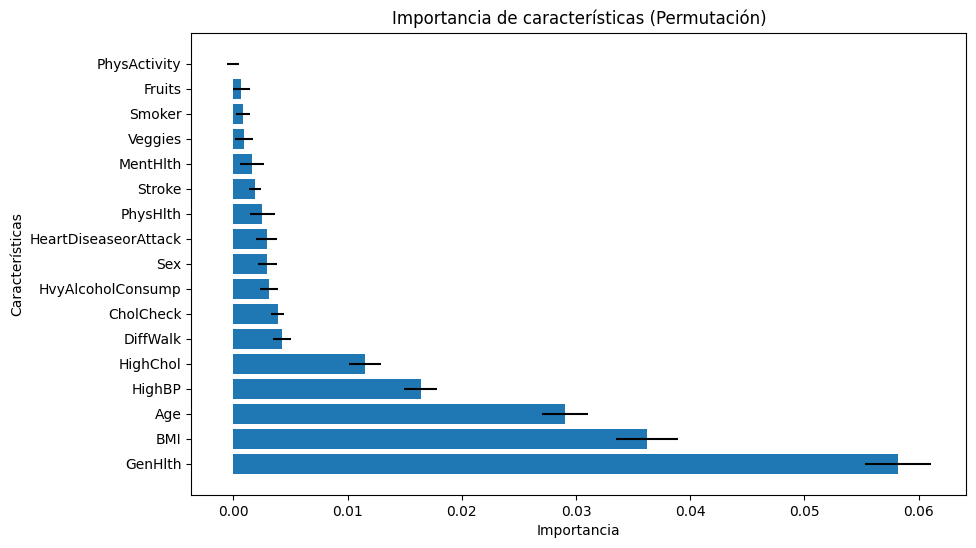

In [7]:
from sklearn.inspection import permutation_importance

# Realizar el proceso de permutación 30 veces
n_repeats = 30
result = permutation_importance(pipeline, X_test, y_test, n_repeats=n_repeats, random_state=42)

# Obtener la importancia promedio y desviación estándar
importance_mean = result.importances_mean
importance_std = result.importances_std

# Obtener los nombres de las características
feature_names = X.columns

# Ordenar las características por importancia promedio en orden descendente
indices = importance_mean.argsort()[::-1]

# Visualizar los resultados en un gráfico
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importance_mean[indices], xerr=importance_std[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Importancia')
plt.ylabel('Características')
plt.title('Importancia de características (Permutación)')
plt.show()

1. En este método de permutación, la importancia de una característica que tanto varia el rendimiento del modelo cuando los valores de esa característica se permutan de forma aleatoria

2. GenHtlh, BMI, Age y High BP, si tiene sentido pero en mi opinion HighChol podria haber tenido mas importancia

3. Mucho, dado que al no ser experto en el tema o incluso un experto podria sorprenderse de la imporatancia obtenida

4. Ventajas:
- No asume una relación lineal
- Considera interacciones entre características
- Robusto a características correlacionadas

Desventajas:
-Mayor costo computacional
-Sensible a la elección de la métrica de rendimiento
-Requiere conjuntos de datos completos

*texte en italique*## 5. Métodos Agnósticos Locales (2 pt)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### Parte A (0.4 pt)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

Cada número representa la relevancia que tiene cada una de las variables en el modelo dependiendo del valor absoluto de este. Por otro lado, es posible atribuir significado al signo de cada valor, ya que, un valor positivo implica que dicha variable guarda una relación directa con la ocurrencia del caso de estudio, y en sentido opuesto un valor negativo guarda relación con la no ocurrencia de dicho evento considerando el shap value para dicha característica.

In [8]:
!pip install shap

In [9]:
!pip install --upgrade shap

In [10]:
import shap
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [11]:
explainer = shap.Explainer(pipeline.named_steps['model'], X_test)

#Calcular los SHAP values para un conjunto de datos de prueba
shap_values = explainer(df, check_additivity=False)

100%|===================| 70432/70692 [01:42<00:00]       

### Parte B (0.4 pt)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes?
- ¿Existe algún patrón común entre las instancias analizadas?
- ¿Es posible generalizar estas conclusiones a todo el dataset?

Dada la observarvación de los gráficos se visualizan que las variables "Age" y "HighCol" son relevantes, ya que, sus shap values son elevados en comparación a las otras que poseen valores cercanos a cero, es decir, no afectan mayormente clasificación. Por otro lado si existen patrones comunes entre las instancias realizadas, ya que, se ve que para las 3 instancias las variables "Age" y "HighCol" son relevantes para predecir la diabetes. Finalmente, es importante decir que no se puede generalizar estas conclusiones, dado que son para un estudio local y no global de la enfermedad porque no se estan considerando factores que podrian ocurrar la ocurrencia de diabetes, tales como: zona geografica, ambiente, entorno , etc.

In [ ]:
idx=1
shap.plots.waterfall(shap_values[idx,:],
                     max_display=14)

In [ ]:
idx=9
shap.plots.waterfall(shap_values[idx,:],
                     max_display=14)

In [ ]:
idx=150
shap.plots.waterfall(shap_values[idx,:],
                     max_display=14)

### Parte C (0.4 pt)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

In [ ]:
shap.summary_plot(shap_values, df)

### Parte D (0.4 pt)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [ ]:
#obtenemos los shap values
shap_values_abs = np.mean(np.abs(shap_values.values), axis=0)

#Obtenemos los nombres ordenados de mayor a menor
feature_importance_names = df.columns[shap_values_abs.argsort()]
for name in feature_importance_names[:5]:
    shap.dependence_plot(name, shap_values.values, df)
    shap.plots.scatter(shap_values[:,name],
                   color=shap_values)

In [ ]:
for name in feature_importance_names[:5]:
    #shap.dependence_plot(name, shap_values.values, X)
    shap.plots.scatter(shap_values[:,name],
                       color=shap_values, xmin=0)

### Parte E (0.4 pt)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [ ]:
X100 = shap.utils.sample(df, 1000)

for i in feature_importance_names[:5]:
    sample_ind = 40
    feature_index = df.columns.get_loc(i)  # Obtener el índice de la característica en el DataFrame
    shap_values_subset = shap_values[sample_ind:sample_ind + 1, feature_index]

    shap.partial_dependence_plot(
        i, model.predict, X100, model_expected_value=True,
        feature_expected_value=True, ice=True,
        shap_values=shap_values_subset
    )

In [ ]:
X100 = shap.utils.sample(df, 1000)
sample_ind = 40
shap.partial_dependence_plot('Age', model.predict, X100, model_expected_value=True,feature_expected_value=True, ice=True, shap_values=shap_values[sample_ind:sample_ind + 1,:])

## 6. Sistema de Reglas! (1 pt)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
!pip install alibi

In [ ]:
from alibi.explainers import AnchorTabular
from alibi.utils.data import gen_category_map

#Generación de reglas explicativas
explainer = AnchorTabular(model.predict, df.columns, categorical_names=gen_category_map(df))
explainer.fit(df.values)

#Explicación de las predicciones para las observaciones 1000, 3001 y 5751
observacion_1000 = df.iloc[1000].values.reshape(1, -1)
observacion_3001 = df.iloc[3001].values.reshape(1, -1)
observacion_5751 = df.iloc[5751].values.reshape(1, -1)

explicacion_1000 = explainer.explain(observacion_1000)
explicacion_3001 = explainer.explain(observacion_3001)
explicacion_5751 = explainer.explain(observacion_5751)

#Obtención de las reglas propuestas
reglas_1000 = explicacion_1000['names']
reglas_3001 = explicacion_3001['names']
reglas_5751 = explicacion_5751['names']

print("Reglas propuestas para la observación 1000:", reglas_1000)
print("Reglas propuestas para la observación 3001:", reglas_3001)
print("Reglas propuestas para la observación 5751:", reglas_5751)

# Retrospectiva... (1 pt)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

**Importante!!**

No se pudo comentar desde la parte C en adelante ,dado que tras reiteradas ejecuciones del código el colab se caía por saturación de la RAM. Sin embargo, los códigos respectivos se encuetran en cada una de las partes solicitadas.

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>